In [1]:
from pathlib import Path
import vaex
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import pandas as pd

from scipy import interpolate

from scipy.stats import norm
from scipy.optimize import minimize


import gaiaxpy as gxp 

import emcee
import corner

import os

from multiprocessing import Pool
from matplotlib.pyplot import figure, show
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


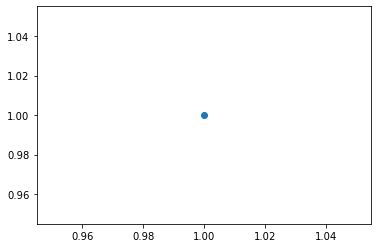

In [2]:
plt.scatter([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)

plt.show()

In [3]:
tester = "/Users/users/spirov/PopProject/"

#sf = vaex.open( tester+ "gd.hdf5")
df = vaex.open(tester+"gooderBoy.hdf5")

In [4]:
def logL_simp(p, data):
    mu1 = p[0]
    mu2 = p[1]
    alpha = p[2]
    
    color = data[0]
    mag = data[1]
    err = data[2]

    if alpha < 0 or alpha > 1.0 or mu1>np.mean(color) or mu2<np.mean(color):
        return(-np.inf)

    
    Ntot = len(color)
    
    var1 = err**2 
    var2 = err**2 

    _norm1 = 1/np.sqrt(2*np.pi*var1)
    _norm2 = 1/np.sqrt(2*np.pi*var2)

    P1 = _norm1 * np.exp(-(color - mu1)**2/(2*var1))
    P2 = _norm2 * np.exp(-(color - mu2)**2/(2*var2))

    P = Ntot*alpha*P1 + Ntot*(1 - alpha)*P2

    lnL = np.ma.sum(np.ma.log(P))
    return lnL



0


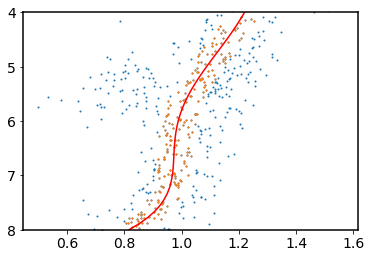

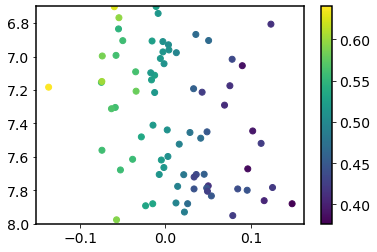

1


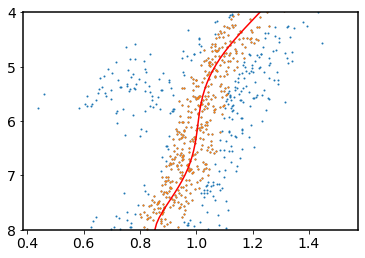

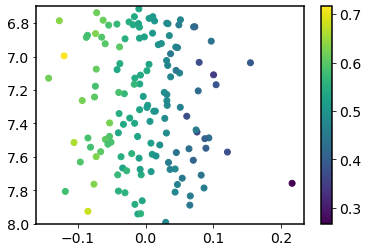

2


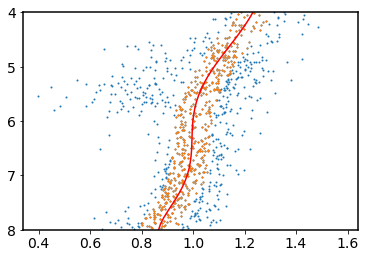

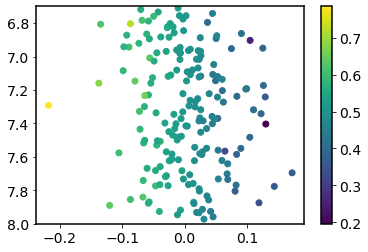

3


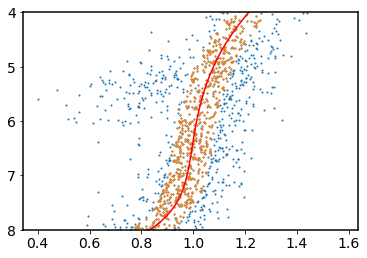

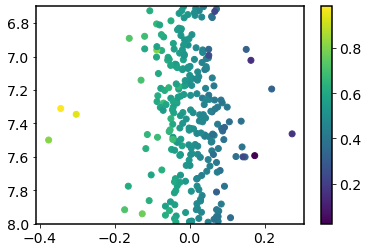

4


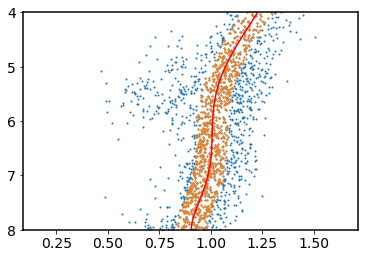

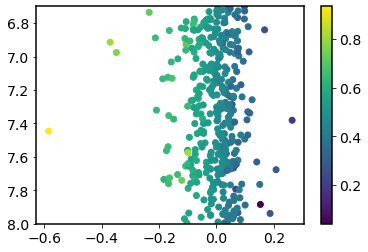

5


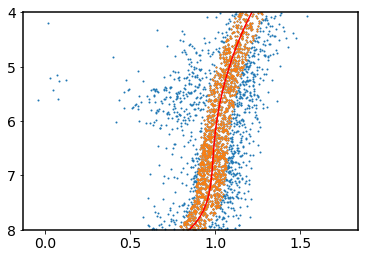

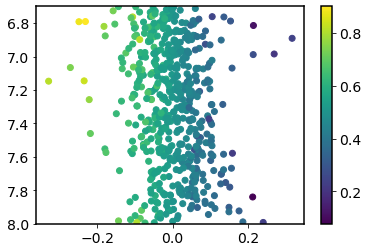

6


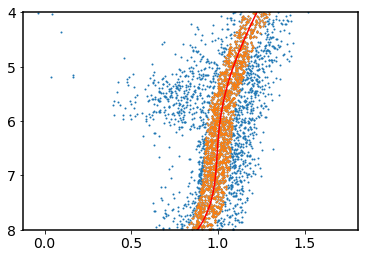

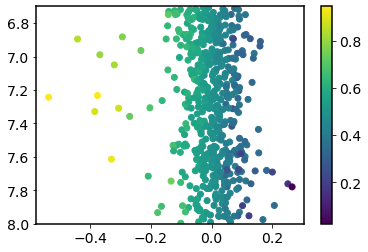

7


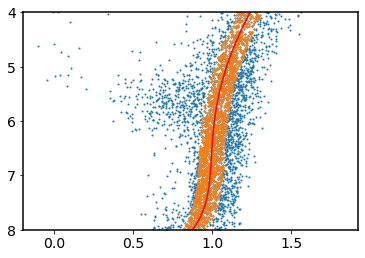

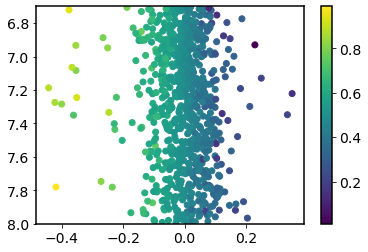

8


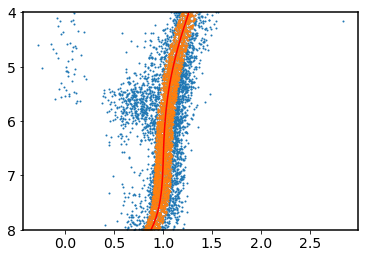

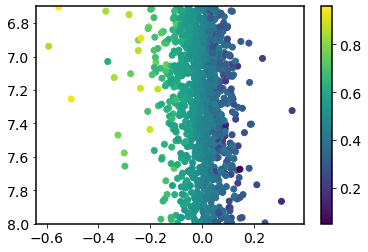

9


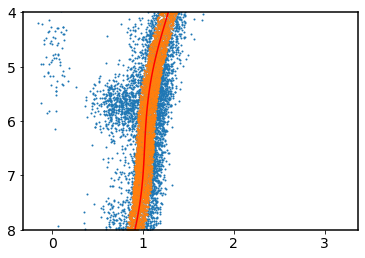

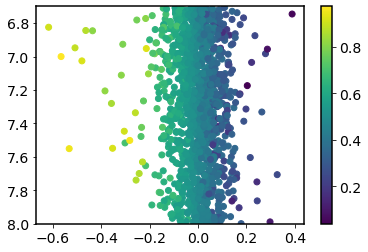

10


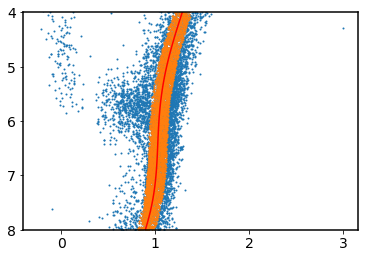

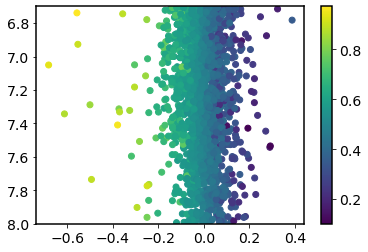

11


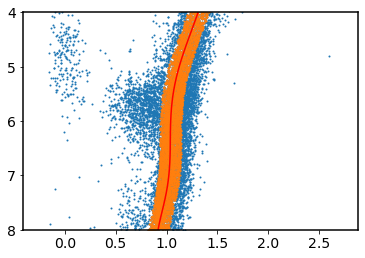

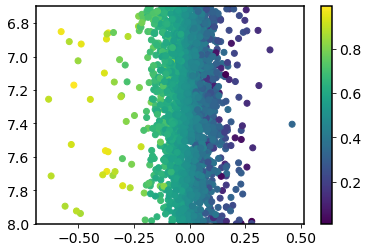

12


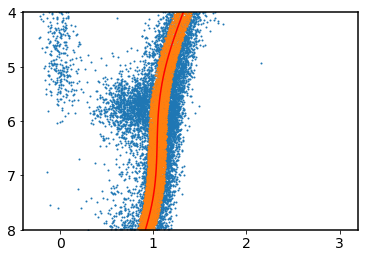

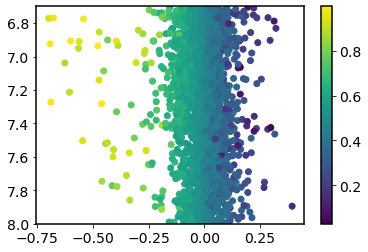

13


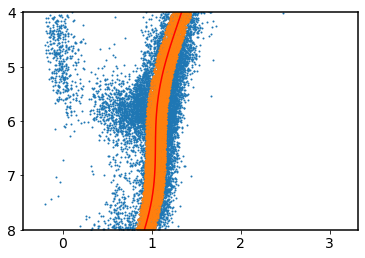

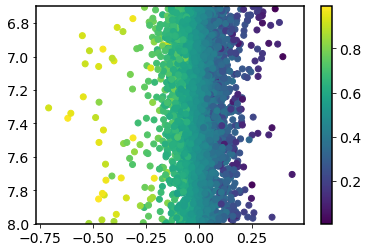

14


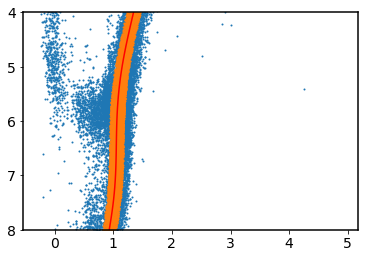

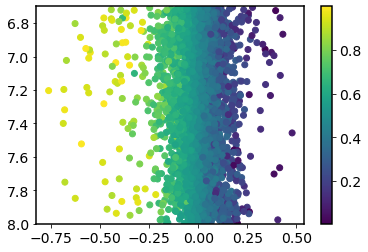

15


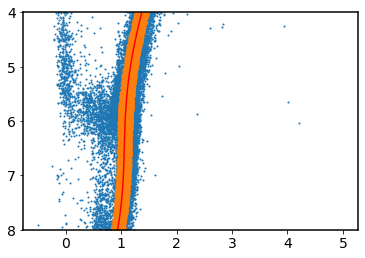

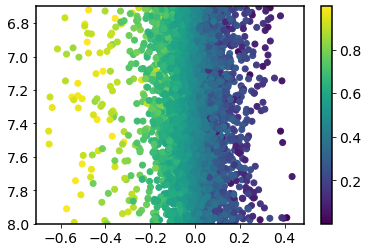

16


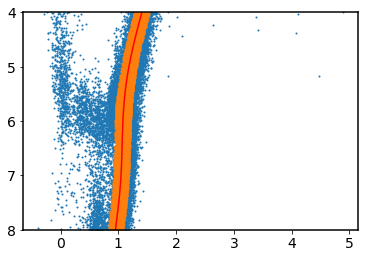

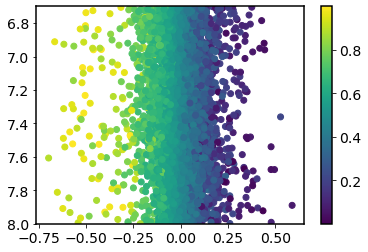

17


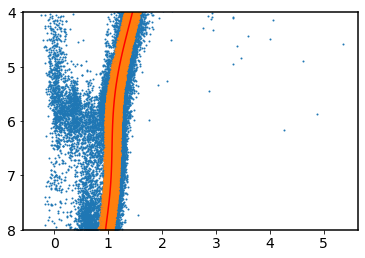

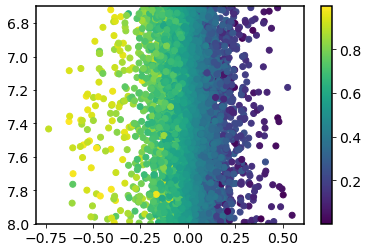

18


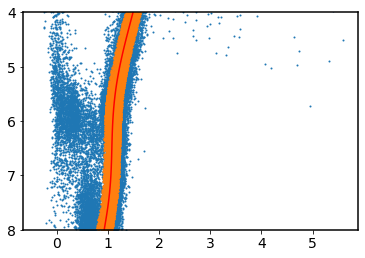

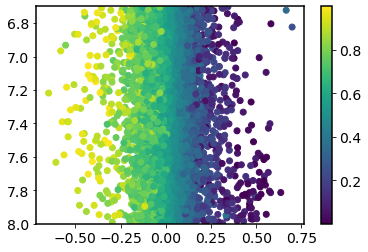

19


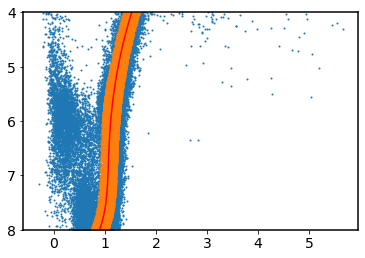

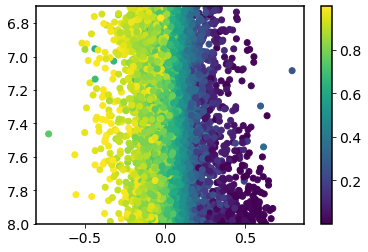

In [5]:
zPoint = -1.54

t = -1
b = -2.8
n=20


zPoints = np.linspace(b,t,n)
zRange = (t-b)/n


#plt.figure(figsize=(10,8))
#plt.ylabel('Likelihoods', fontsize=14)



idArrays = []
probArrays= []
params = []

ras = []

func = lambda x: -1*log_likelihood(x, N, N_error)

for i, zPoint in  enumerate(zPoints[:]):
    print(i)
    
    bot = np.round(zPoint-0.5*zRange,3)
    top = np.round(zPoint+0.5*zRange,3)
    
    cut = (df.mh_xgboost>bot)*(df.mh_xgboost<top)
    subFrame = df[cut]
    
    Tlim = 5.5e5
    
    tcut0 = subFrame.teff_xgboost<Tlim
    
    sbFrame = subFrame[tcut0]
        
    top = 6.7
    bot = 8
    
    TTOP=2.5
    
    rgbFrame = sbFrame[(sbFrame.Mag<bot)] #*subFrame.Mag>top]
    
    nG = rgbFrame.Mag.values
    brp = rgbFrame.bprp.values
    
    #tcut = rgbFrame.teff_xgboost<Tlim
    #========================================= replace tcut with sigma clip========================
    
    fbc = []
    fmu = []
    fsig = []
    
    bins = np.linspace(TTOP, bot+0.1, 15)

    
    for xmin, xmax in zip(bins[:-1], bins[1:]):
        cen = (xmax + xmin)/2
        j = (nG < xmax)*(nG >= xmin)

        if len(np.where(j==True)[0]) ==0:
            #print("skip")
            continue

        cs = brp[j]
        cs = cs[~np.isnan(cs)]
        mc = np.median(cs)
        std = np.std(cs)
        fbc.append(cen)
        fmu.append(mc)
        fsig.append(std)
    
    pf = np.polyfit(fbc,fmu, 6)
    ff = lambda x: np.polyval(pf,x)
    
    xs = np.linspace(bot,TTOP)
    plt.scatter(brp,nG,s=1)
    plt.plot(ff(xs),xs,c='r')
    
    tor = 0.7
    
    filt = np.where(np.abs(brp-ff(nG))<std*tor,True,False)
    
    
    plt.scatter(brp[filt],nG[filt],s=1)
    plt.ylim(bot,4)
    plt.show()
    #break 
    # =======================================
    
    tc = vaex.from_arrays(filt = filt)


    rgbFrame = sbFrame[(sbFrame.Mag<bot)]
    
    filtRgbFrame = tc.join(rgbFrame)
    
    del rgbFrame
    
    filtRgbFrame = filtRgbFrame[filtRgbFrame.filt==1]
    
    #print("w")
    #break
    
        
    col = filtRgbFrame.CustomCol.values
    nG = filtRgbFrame.Mag.values
    
    
    point = bot-0.5
    

    
    bc =[]
    mu=[]
    sig=[]
    isig=[]

    for xmin, xmax in zip(bins[:-1], bins[1:]):
        cen = (xmax + xmin)/2
        j = (nG < xmax)*(nG >= xmin)

        if len(np.where(j==True)[0]) ==0:
            #print("skip")
            continue

        cs = col[j]
        cs = cs[~np.isnan(cs)]
        mc = np.median(cs)
        std = np.std(cs)
        bc.append(cen)
        mu.append(mc)
        sig.append(std)

    p = np.polyfit(bc,mu, 6)
    f = lambda x: np.polyval(p,x)

    X = np.linspace(top,point)


    clensedCol = col[~np.isnan(col)]
    cleansedMG = nG[~np.isnan(col)]

    zone = np.logical_and(cleansedMG<bot, cleansedMG>top)

   # rgbFrame.viz.scatter("CustomCol","Mag",s=1)
   # plt.plot(f(X),X,c='r')
   #plt.ylim(10,6)
   # plt.show()
    
    MG = cleansedMG
    NC = clensedCol - f(MG)

    MG = MG[zone]

    N=NC[zone]

    N_error = filtRgbFrame.error_color_mag.values[~np.isnan(col)][zone]
    ids = filtRgbFrame.source_id.values[~np.isnan(col)][zone]
    
    
    Jpas_data_actual = np.array([N, MG, N_error])
    
    func4 = lambda x: -1*logL_simp(x, Jpas_data_actual)
    res4 = minimize(func4, (-0.1, 0.1, 0.53), method='SLSQP', tol=1e-10)
    
    mu1, mu2, alpha = res4.x
    
    
    _norm1 = 1/np.sqrt(2*np.pi*N_error)
    _norm2 = 1/np.sqrt(2*np.pi*N_error)
    
    P1 = _norm1 * np.exp(-(N - mu1)**2/(2*N_error))
    P2 = _norm2 * np.exp(-(N - mu2)**2/(2*N_error))
    
    gaussian_ratio = P1/(P1+P2)
    
    idArrays.append(ids)
    probArrays.append(gaussian_ratio)
    params.append(res4.x)
    
    ctrl = cen #filtRgbFrame.ra.values[~np.isnan(col)][zone]
    
    plt.scatter(N,MG,c=gaussian_ratio)
    plt.colorbar()
    plt.ylim(bot,top)
    plt.show()
    ras.append(ctrl)
    
   # if i ==1:
    #    break 
    
  #  break
    

In [6]:
finIDs = []
finProbs = []
finControl = []



for i in range(len(idArrays)):
    ids = idArrays[i]
    probs = probArrays[i]
    ctrls = ras[i]
    
    for j in range(len(ids)):
        finIDs.append(ids[j])
        finProbs.append(probs[j])
        finControl.append(ctrls)

params = np.array(params)

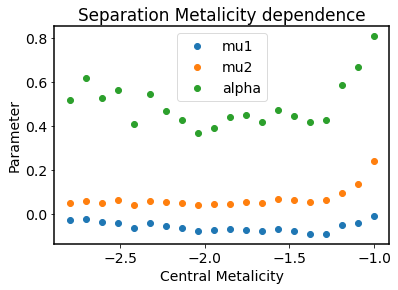

In [7]:

plt.scatter(zPoints,params[:,0],label="mu1")
plt.scatter(zPoints,params[:,1],label="mu2")
plt.scatter(zPoints,params[:,2],label="alpha")
plt.title("Separation Metalicity dependence")
plt.xlabel("Central Metalicity")
plt.ylabel("Parameter")
plt.legend()

plt.show()



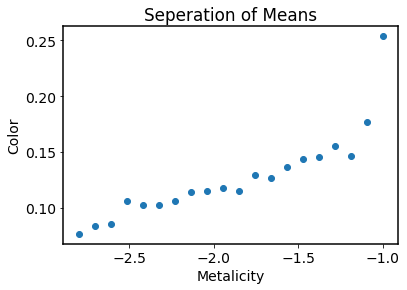

In [8]:

plt.scatter(zPoints,np.abs(params[:,0]-params[:,1]),label="dmu1")
plt.title("Seperation of Means")
plt.xlabel("Metalicity")
plt.ylabel("Color")
plt.show()

In [7]:
func4 = lambda x: -1*logL_simp(x, Jpas_data_actual)
res4 = minimize(func4, (-0.1, 0.1, 0.53), method='SLSQP', tol=1e-10,options = {"maxiter":1e5})

In [9]:
myFrame = vaex.from_arrays(source_id = finIDs, population_likelyhood = finProbs, testColumn = finControl)

In [10]:
myFrame

#,source_id,population_likelyhood,testColumn
0,374801699771696640,0.49570624781218003,15.17828319486879
1,705188863561891328,0.4239259696856772,130.89022527893843
2,1017001736904240256,0.4437260861280305,132.32491519336995
3,1051781316914184704,0.4905757732648673,155.8978710511388
4,1164496583205187200,0.5153364445938299,232.695652277178
...,...,...,...
"38,806",6915014689362732672,0.8364535608342755,311.2828730955171
"38,807",6915901754728171264,0.5140506484725126,316.7647816989478
"38,808",6916201887043072640,0.8025180463928979,315.5637495183567
"38,809",6916889249314723200,0.8503221541153295,314.0581130112494


In [ ]:
res4

In [11]:
fdf = myFrame.drop("testColumn")

In [12]:
fdf.export_hdf5("likelyhoodCatalog.hdf5")

# Playing around

In [13]:
myFrame[myFrame.population_likelyhood > 0.8]

#,source_id,population_likelyhood,testColumn
0,883042050539140992,0.8189822262699962,106.4262470703612
1,366303780558169344,0.9860236523158956,5.916803257475361
2,1925229540091389184,0.8091827733030913,353.20307086442494
3,3507831461456418688,0.8138498105457221,199.26341229588215
4,6183795820024064256,0.9450664146300939,193.0213667195329
...,...,...,...
"3,910",6914417310951757440,0.8890960340398967,311.31577542926
"3,911",6914598867810026496,0.8148325573511014,310.5651513735349
"3,912",6915014689362732672,0.8364535608342755,311.2828730955171
"3,913",6916201887043072640,0.8025180463928979,315.5637495183567


In [14]:
myFrame[myFrame.population_likelyhood < 0.2]

#,source_id,population_likelyhood,testColumn
0,2751918729189660032,0.16619070928331514,3.174426038840464
1,5561088852745448064,0.15122929699823498,108.746304293759
2,5809240964921136128,0.02087842580095228,250.59350960221528
3,1950571943088087936,0.036293435319393955,323.0213851949642
4,5948205903111279232,0.17883462524571406,265.51112355064697
...,...,...,...
"1,532",6870324730019755520,0.038392721658476445,298.0282225436266
"1,533",6871241928873829248,0.15412488500713753,299.7311093240054
"1,534",6874050837484659712,0.044631075870152734,302.5313146948987
"1,535",6887677016366232064,0.12383252337346158,310.5760890578438


In [15]:
funnyFrame = myFrame.join(df, on = "source_id",how="inner",lsuffix="_L")

In [16]:
funnyFrame

#,source_id_L,population_likelyhood,testColumn,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_matched_transits,visibility_periods_used,ruwe,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,radial_velocity,radial_velocity_error,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,l,b,non_single_star,parallax_corr,parallax_corr_error,Gaia2_mag_C1B431,Gaia2_mag_C1B556,Gaia2_mag_C1B655,Gaia2_mag_C1B768,Gaia2_mag_C1B916,Gaia2_mag_C1M326,Gaia2_mag_C1M344,Gaia2_mag_C1M379,Gaia2_mag_C1M395,Gaia2_mag_C1M410,Gaia2_mag_C1M467,Gaia2_mag_C1M506,Gaia2_mag_C1M515,Gaia2_mag_C1M549,Gaia2_mag_C1M656,Gaia2_mag_C1M716,Gaia2_mag_C1M747,Gaia2_mag_C1M825,Gaia2_mag_C1M861,Gaia2_mag_C1M965,Gaia2_flux_C1B431,Gaia2_flux_C1B556,Gaia2_flux_C1B655,Gaia2_flux_C1B768,Gaia2_flux_C1B916,Gaia2_flux_C1M326,Gaia2_flux_C1M344,Gaia2_flux_C1M379,Gaia2_flux_C1M395,Gaia2_flux_C1M410,Gaia2_flux_C1M467,Gaia2_flux_C1M506,Gaia2_flux_C1M515,Gaia2_flux_C1M549,Gaia2_flux_C1M656,Gaia2_flux_C1M716,Gaia2_flux_C1M747,Gaia2_flux_C1M825,Gaia2_flux_C1M861,Gaia2_flux_C1M965,Gaia2_flux_error_C1B431,Gaia2_flux_error_C1B556,Gaia2_flux_error_C1B655,Gaia2_flux_error_C1B768,Gaia2_flux_error_C1B916,Gaia2_flux_error_C1M326,Gaia2_flux_error_C1M344,Gaia2_flux_error_C1M379,Gaia2_flux_error_C1M395,Gaia2_flux_error_C1M410,Gaia2_flux_error_C1M467,Gaia2_flux_error_C1M506,Gaia2_flux_error_C1M515,Gaia2_flux_error_C1M549,Gaia2_flux_error_C1M656,Gaia2_flux_error_C1M716,...,Jpas_flux_J0780,Jpas_flux_J0790,Jpas_flux_J0800,Jpas_flux_J0810,Jpas_flux_J0820,Jpas_flux_J0830,Jpas_flux_J0840,Jpas_flux_J0850,Jpas_flux_J0860,Jpas_flux_J0870,Jpas_flux_J0880,Jpas_flux_J0890,Jpas_flux_J0900,Jpas_flux_J0910,Jpas_flux_J1007,Jpas_flux_error_uJava,Jpas_flux_error_u,Jpas_flux_error_J0378,Jpas_flux_error_J0390,Jpas_flux_error_J0400,Jpas_flux_error_J0410,Jpas_flux_error_J0420,Jpas_flux_error_J0430,Jpas_flux_error_J0440,Jpas_flux_error_J0450,Jpas_flux_error_J0460,Jpas_flux_error_J0470,Jpas_flux_error_J0480,Jpas_flux_error_gSDSS,Jpas_flux_error_J0490,Jpas_flux_error_J0500,Jpas_flux_error_J0510,Jpas_flux_error_J0520,Jpas_flux_error_J0530,Jpas_flux_error_J0540,Jpas_flux_error_J0550,Jpas_flux_error_J0560,Jpas_flux_error_J0570,Jpas_flux_error_J0580,Jpas_flux_error_J0590,Jpas_flux_error_J0600,Jpas_flux_error_J0610,Jpas_flux_error_J0620,Jpas_flux_error_rSDSS,Jpas_flux_error_J0630,Jpas_flux_error_J0640,Jpas_flux_error_J0650,Jpas_flux_error_J0660,Jpas_flux_error_J0670,Jpas_flux_error_J0680,Jpas_flux_error_J0690,Jpas_flux_error_J0700,Jpas_flux_error_J0710,Jpas_flux_error_J0720,Jpas_flux_error_J0730,Jpas_flux_error_J0740,Jpas_flux_error_J0750,Jpas_flux_error_J0760,Jpas_flux_error_iSDSS,Jpas_flux_error_J0770,Jpas_flux_error_J0780,Jpas_flux_error_J0790,Jpas_flux_error_J0800,Jpas_flux_error_J0810,Jpas_flux_error_J0820,Jpas_flux_error_J0830,Jpas_flux_error_J0840,Jpas_flux_error_J0850,Jpas_flux_error_J0860,Jpas_flux_error_J0870,Jpas_flux_error_J0880,Jpas_flux_error_J0890,Jpas_flux_error_J0900,Jpas_flux_error_J0910,Jpas_flux_error_J1007,distance,in_training_sample,mh_xgboost,teff_xgboost,logg_xgboost,ebv,Mag,JfSSDS,Jf430,Jf410,Jf400,Jfu,JfeSSDS,Jfe430,Jfe410,Jfe400,Jfeu,JpasHigh,JpasMid,Jpas420,Jpas430,JpasSDSS,CustomCol,error_color_mag,bprp
0,374801699771696640,0.49570624781218003,15.17828319486879,374801699771696640,15.17828319486879,42.05712275908863,0.3897058916944562,0.023296252,-5.192728795923629,0.019358825,-3.7434274696866514,0.016341548,-0.11518933,0.09725124,-0.009307845,0.0,0.0,31,47,18,0.9427912,423,26490.900088837378,5.5524035,14.629625,49,13793.073813349622,14.682805,14.989389,49,18398.13926176496,16.520489,14.08596,-207.60455,5.231120811131935,5500.0,3.5,-2.0,110.0,124.773

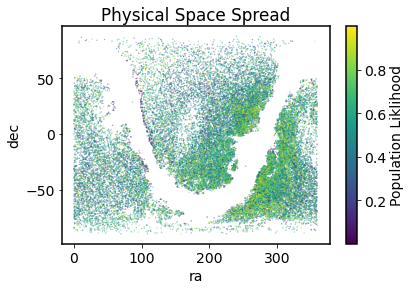

In [17]:
ra = funnyFrame.ra.values
dec = funnyFrame.dec.values
pl = funnyFrame.population_likelyhood.values

plt.scatter(ra,dec,c=pl,s=0.05)

plt.title("Physical Space Spread")
plt.colorbar().set_label("Population Liklihood")
plt.xlabel("ra")
plt.ylabel("dec")
plt.show()


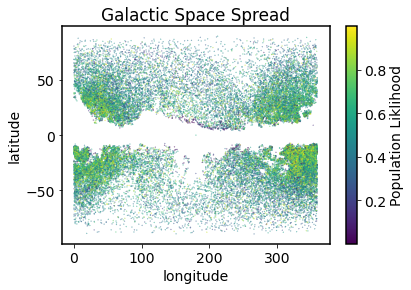

In [18]:
l = funnyFrame.l.values
b = funnyFrame.b.values


plt.scatter(l,b,c=pl,s=0.05)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Galactic Space Spread")
plt.colorbar().set_label("Population Liklihood")
plt.show()